<a href="https://colab.research.google.com/github/compressed-sensing/algorithms/blob/feature%2Fnotebooks/notebooks/TV_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy.signal as signal
from scipy.signal import convolve2d
import scipy.fft as fft
import urllib.request
from skimage.metrics import peak_signal_noise_ratio as PSNR
import time

# Import image

<class 'numpy.ndarray'>
(512, 512)


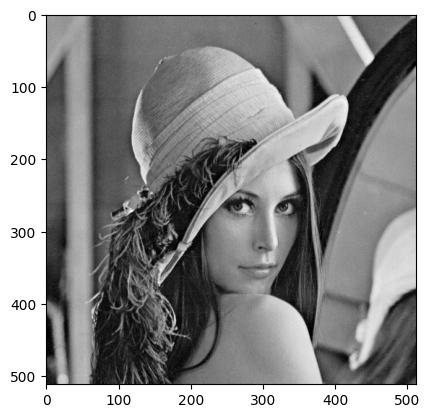

In [ ]:
# Reading image (grayscale)
url = 'https://i.stack.imgur.com/kP0u2.png'
  # url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRsK5QFJ1arEQlnHEJ-020xbO30BgdYgPJBg&usqp=CAU'
  #url='https://unsplash.com/photos/IoZA1Mwiq2g/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTZ8fGJsYWNrJTIwYW5kJTIwd2hpdGUlMjBmbG93ZXJ8ZW58MHx8fHwxNjc5MzQxODY4&force=true&w=640'
with urllib.request.urlopen(url) as url_response:
  img_array = np.asarray(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
# img is a 3-dimensional numpy array (third number indicates channel)
# Converting to (0,1)
x = img.astype(float)/255.
print(type(img)) 
print(img.shape) 
plt.imshow(x, cmap ='gray')

# Define conv and fft functions

In [ ]:
# Define some of the operators that we need...
def conv2d_fft(x, h):
     p0 = x.shape[0]-h.shape[0]
     p1 = x.shape[1]-h.shape[1]
     h_pad = np.pad(h, ((0,p0),(0,p1)))
     Fh = fft.fft2(h_pad)
     Fx = fft.fft2(x)
     return np.real(fft.ifft2(Fx*Fh))

def conv2dT_fft(x, h):
     p0 = x.shape[0]-h.shape[0]
     p1 = x.shape[1]-h.shape[1]
     h_pad = np.pad(h, ((0,p0),(0,p1)))
     Fh = fft.fft2(h_pad)
     Fx = fft.fft2(x)
     return np.real(fft.ifft2(Fx*np.conj(Fh)))

In [ ]:
# def conv2d_fft(x, h):
#   return convolve2d(x, h, mode='same', boundary='wrap')

# def conv2dT_fft(x, h):
#   # rotate the kernel by 180 degrees
#   h_rotated = np.rot90(np.rot90(h))

#   # perform the flipped kernel convolution
#   return convolve2d(x, h_rotated, mode='same', boundary='wrap')

# Noise function

In [ ]:
def awgn(img,n):
  ''' Generating Gaussian Noise 
      with 0 mean and standard deviation n 
      choose n between 0,1 for normalized image '''

  noise = np.random.randn(*img.shape)*n
  # Add the noise to the input image
  noisy_image = img + noise

  return noisy_image

# Add noise to the image

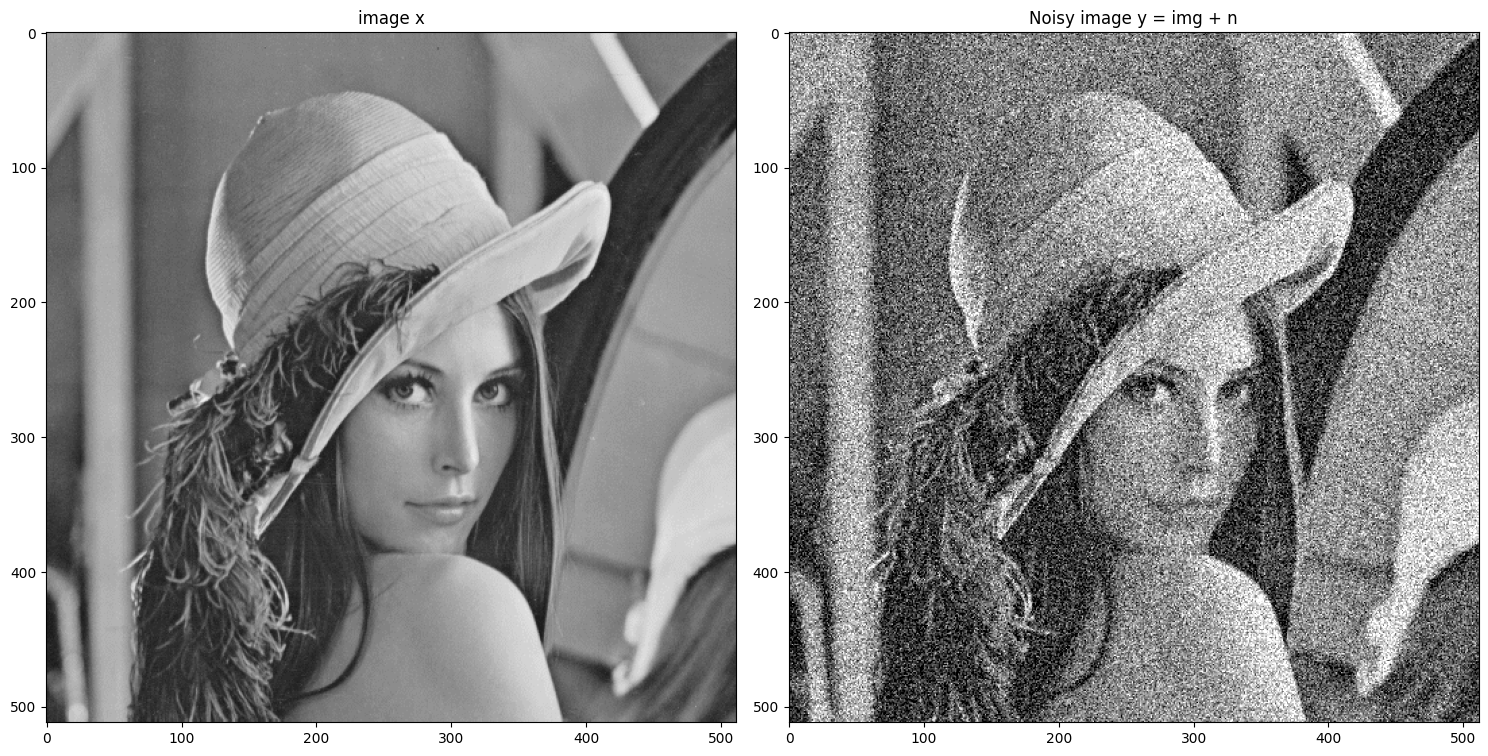

In [ ]:
'''
y1 = img + n
'''
# Add noise to the image
y1 = awgn(x,0.2)

fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(x, cmap='gray', clim=[0,1])
plt.title('image x')
plt.subplot(122)
plt.imshow(y1, cmap='gray', clim=[0,1])
plt.title('Noisy image y = img + n')
plt.tight_layout()
plt.show()

# Gradiant operator

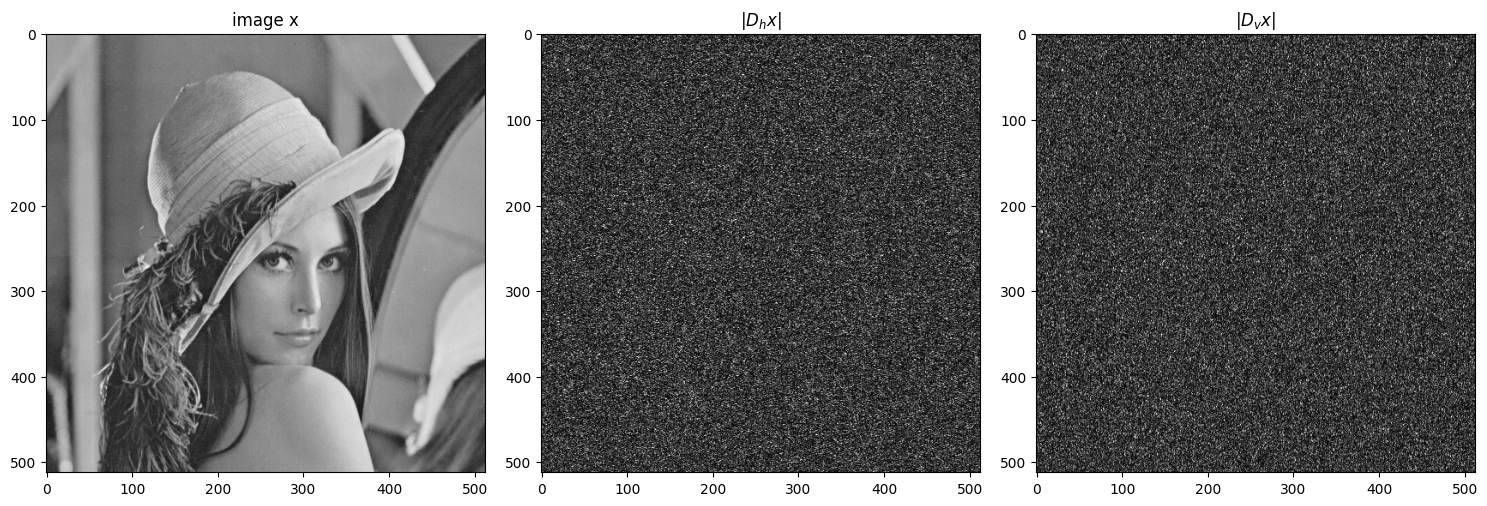

In [ ]:
# define gradient operators
'''
I am testing it with y1 for now
'''
dh = np.array([[1,-1],[0, 0]]) # horizontal gradient filter
dv = np.array([[1, 0],[-1,0]]) # vertical gradient filter

Dh = lambda x: conv2d_fft(x, dh)
Dv = lambda x: conv2d_fft(x, dv)

DhT = lambda x: conv2dT_fft(x, dh)
DvT = lambda x: conv2dT_fft(x, dv)

# plot the image x and the gradient images Dh x and Dv x
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x, cmap='gray', clim=[0,1])
plt.title('image x')
plt.subplot(132)
plt.imshow(np.abs(Dh(y1)), cmap='gray', clim=[0,1])
plt.title(r'$|D_hx|$')
plt.subplot(133)
plt.imshow(np.abs(Dv(y1)), cmap='gray', clim=[0,1])
plt.title(r'$|D_vx|$')
plt.tight_layout()
plt.show()

# TV-denoising Solver
Write TV-denoising formulation with explanation here later

In [ ]:
def TV_denoising(y, lamb = 2, rho=1e1, maxiter=200):
    '''
    TV-denoising solver to solve
    minimize 0.5 |x-y|_2^2 + lambda|Dx|_1
    '''
    # define the soft-thresholding function
    '''
    In the TVD case we have : 
    Vector (v): Dx_(k+1) + u_(k)
    Threshold (t): lamb/rho
    '''
    start = time.time()
    soft_thresh = lambda v, t: np.maximum(np.abs(v)-t, 0.)*np.sign(v)
    
    # DDT
    '''
        DDT = please check notes for fourier transform format
    '''
    # Calculating the difference between sizes x and d for padding purpose
    p0 = x.shape[0]-dh.shape[0]
    p1 = x.shape[1]-dh.shape[1]
    dh_pad = np.pad(dh, ((0,p0),(0,p1)))
    
    p0 = x.shape[0]-dv.shape[0]
    p1 = x.shape[1]-dv.shape[1]
    dv_pad = np.pad(dv, ((0,p0),(0,p1)))
    
    # Refer to Parisima's notes for computing DDT using FFT
    DDT = np.abs(fft.fft2(dh_pad))**2 +\
          np.abs(fft.fft2(dv_pad))**2

# -----------------------------
    # initilize iteration variables
    zh = np.zeros_like(y)
    zv = np.zeros_like(y)
    uh = np.zeros_like(zh)
    uv = np.zeros_like(zv)
    x_hat = np.zeros_like(y)
    # For computing error
    J = np.zeros(maxiter)

    for k in range(maxiter):
        # solve the L2-L2 problem (update x) 
        rhs = y + rho * (DhT(zh) + DvT(zv)) - DhT(uh) - DvT(uv)
        F_rhs = fft.fft2(rhs)
        x_hat = np.real(fft.ifft2(F_rhs/(rho * DDT + 1)))

        # solve the TV problem (update z)
        zh = soft_thresh(Dh(x_hat)+ uh, lamb/rho)
        zv = soft_thresh(Dv(x_hat)+ uv, lamb/rho)

        # update u
        dual_h = Dh(x_hat) - zh
        dual_v = Dv(x_hat) - zv
        uh = uh + dual_h
        uv = uv + dual_v

        # compute the error
        J[k] = (dual_h**2).sum()+(dual_v**2).sum()
    end = time.time()
    return x_hat, J, end-start

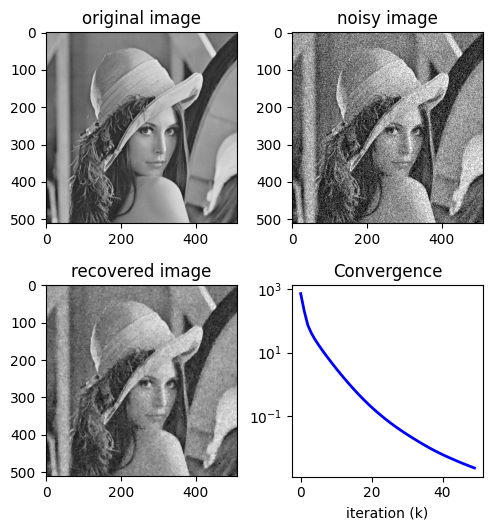

Time taken = 24.2992160320282


In [ ]:

x_hat, J, duration = TV_denoising(y1, lamb = 0.2, rho=2, maxiter=50)

fig = plt.figure()
fig.set_size_inches(5,7.5)
ax = fig.add_subplot(321)
ax.imshow(x, cmap='gray', clim=[0,1])
plt.title('original image')
ax2 = fig.add_subplot(322)
ax2.imshow(y1, cmap='gray', clim=[0,1])
plt.title('noisy image')
ax3 = fig.add_subplot(323)
ax3.imshow(x_hat, cmap='gray', clim=[0,1])
plt.title('recovered image')
ax4 = fig.add_subplot(324)
ax4.semilogy(range(len(J)), J, 'b-', lw=2)
plt.title('Convergence')
plt.xlabel('iteration (k)')
plt.tight_layout()
plt.show()
print(f"Time taken = {duration}")


22.413841638095533


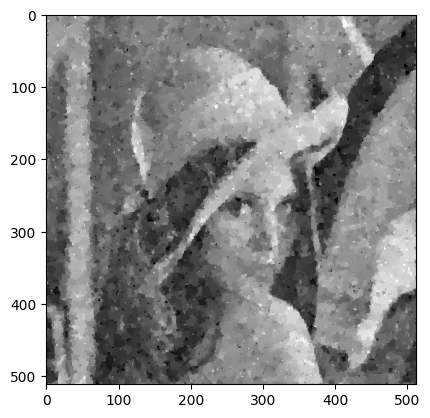

In [ ]:
y2 = awgn(x,0.5)
x_hat, J, duration = TV_denoising(y2, lamb = 0.7, rho=2, maxiter=50)
plt.imshow(x_hat, cmap='gray', clim=[0,1])
print(PSNR(x, x_hat.clip(0,1)))

# Comparession between noise and lambda

In [ ]:
# Loop over for different level of noise and lambda
# levels of noise
# under construction
n = [0.05, 0.1, 0.2, 0.5]
lam = np.arange(0.05, 0.51, 0.01)
lam = np.concatenate((lam, np.array([0.1, 0.3])))
denoised_list = []
time_list = []
psnr_list = []
cost_list = []
for i in n:
  y = awgn(x,i)
  # store images
  c = []
  # Store J
  converg = []
  # store psnr
  npsnr = []
  # store time
  ntime = []
  for j in lam:
    x_hat, J, duration = TV_denoising(y, j, rho=2, maxiter=50)
    c.append(x_hat)
    converg.append(J)
    ntime.append(duration)
    npsnr.append(PSNR(x, x_hat.clip(0,1)))
  denoised_list.append(c)
  time_list.append(ntime)
  psnr_list.append(npsnr)
  cost_list.append(converg)
  # Plot for different lambda
  print(f'Noise level:{i}')

Noise level:0.05
Noise level:0.1
Noise level:0.2
Noise level:0.5


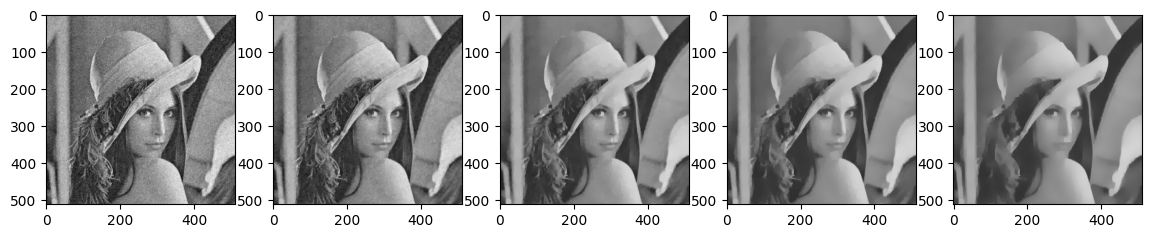

In [ ]:
# Loop over for different level of noise and lambda
# levels of noise
# under construction
n = 0.1
lam = [0.05, 0.1, 0.2, 0.5, 0.9]
y = awgn(x,n)
# store images
c = []
# Store J
converg = []
# store psnr
npsnr = []
# store time
ntime = []
c = 1
fig = plt.figure(figsize=(20,20))
for j in lam:
  x_hat, J, duration = TV_denoising(y, j, rho=2, maxiter=50)
  plt.subplot(1,7,c)
  plt.imshow(x_hat, cmap='gray', clim=[0,1])
  c = c +1


Plot PSNR vs $\lambda$ = (0.05:0.51:0.01) for $\sigma$ = [0.01, 0.1, 0.5] 

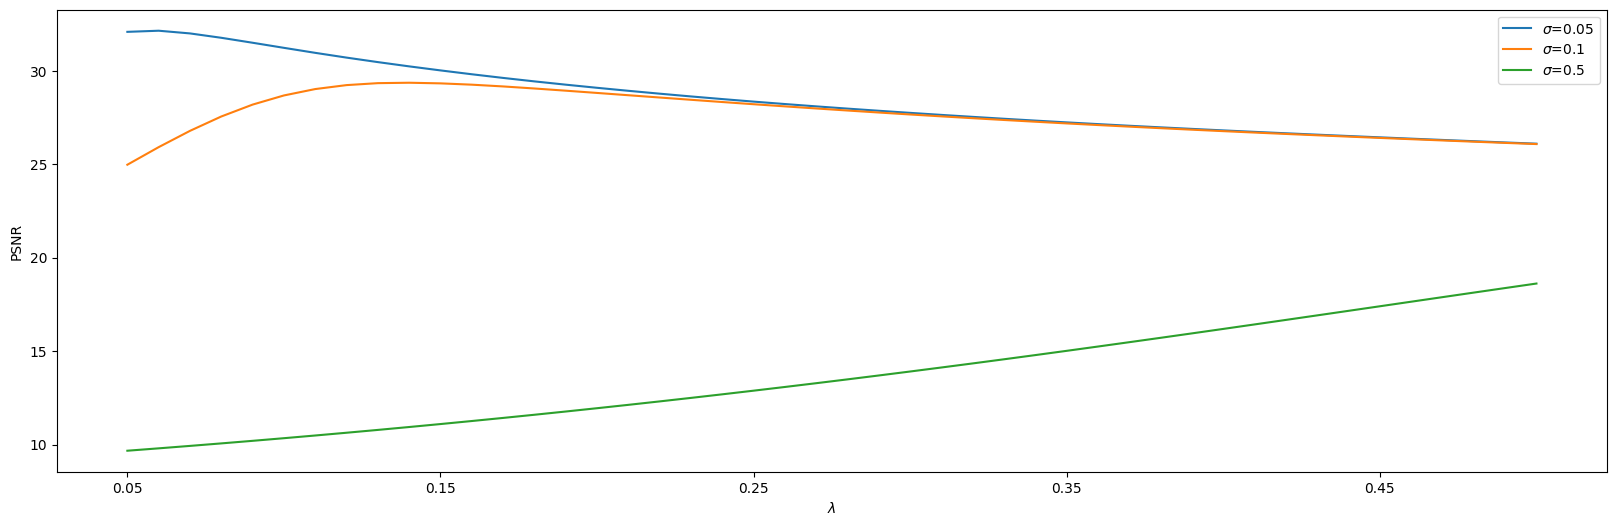

In [ ]:
fig = plt.figure(figsize=(20,6))
plt.plot(psnr_list[0][:lam.shape[0]-2], label=f'$\sigma$={n[0]}')
plt.plot(psnr_list[1][:lam.shape[0]-2], label=f'$\sigma$={n[1]}')
plt.plot(psnr_list[-1][:lam.shape[0]-2], label=f'$\sigma$={n[-1]}')
plt.xticks(np.arange(0, lam.shape[0]-2,10), [f'{val:.2f}' for val in lam[:lam.shape[0]-2:10]])
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('PSNR')
plt.show()

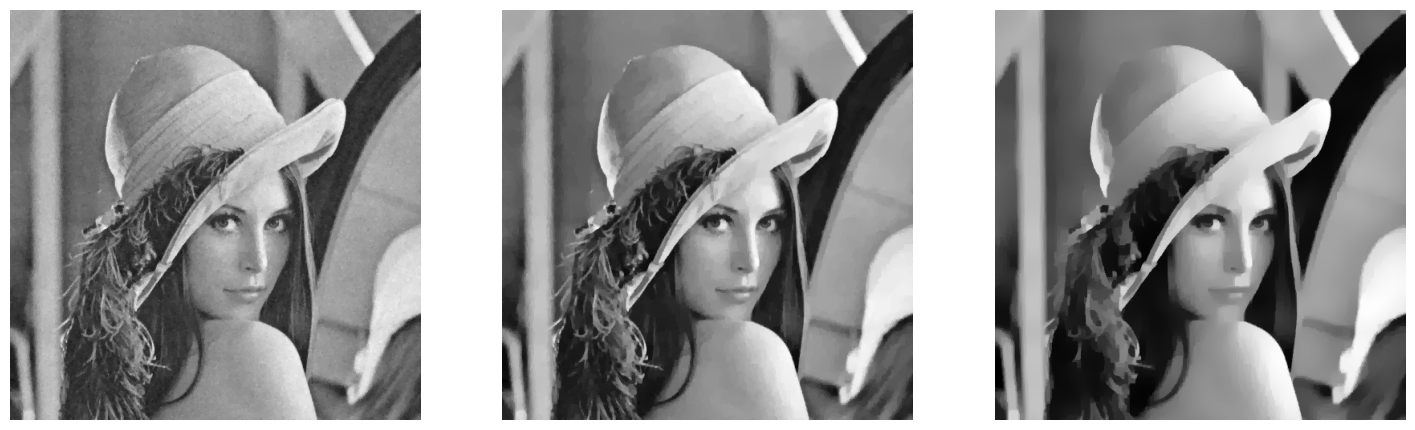

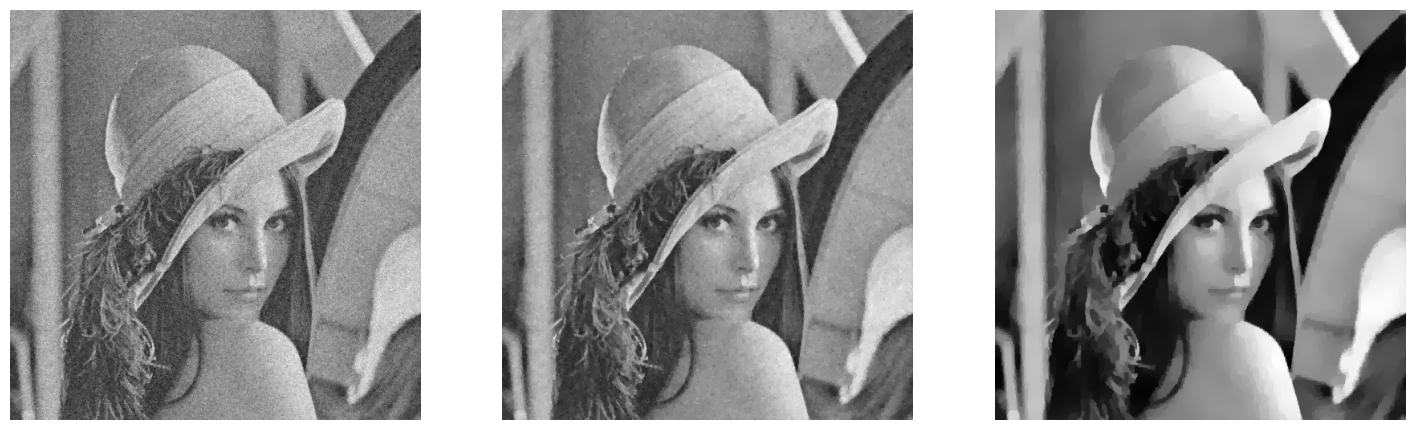

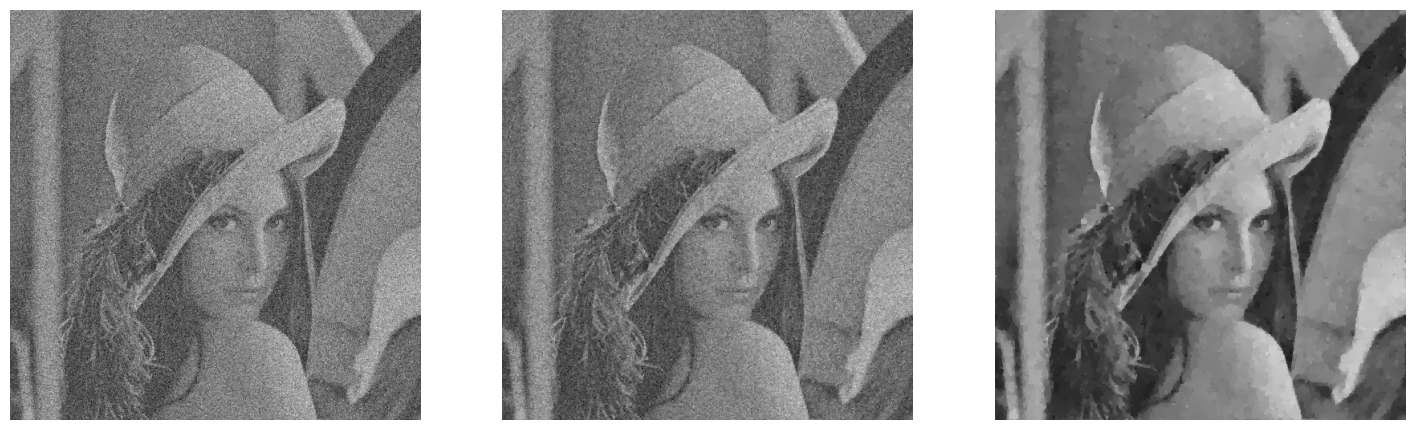

In [ ]:

# for k in range(3):
#   plt.subplot(1,3,k+1)
#   plt.imshow(c[k], cmap='gray')
#   plt.title(f'Lambda:{lam[k]}| time:{ntime[k]:.2f}| PSNR:{npsnr[k]:.2f}')
#   plt.axis('off')
for i in range(len(denoised_list)-1):
  fig = plt.figure(figsize=(18,18))
  plt.subplot(1,1,1)
  plt.imshow(denoised_list[i][0], cmap='gray')
  plt.axis('off')
  plt.subplot(1,1,2)
  plt.axis('off')
  plt.imshow(denoised_list[i][-2], cmap='gray')
  plt.subplot(1,1,3)
  plt.imshow(denoised_list[i][-1], cmap='gray')
  plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

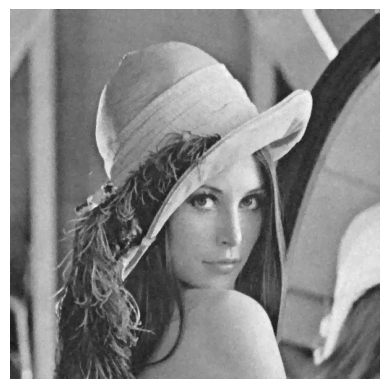

In [ ]:
plt.imshow(denoised_list[0][0], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

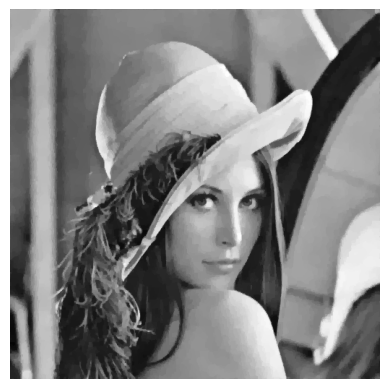

In [ ]:
plt.imshow(denoised_list[0][-2], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

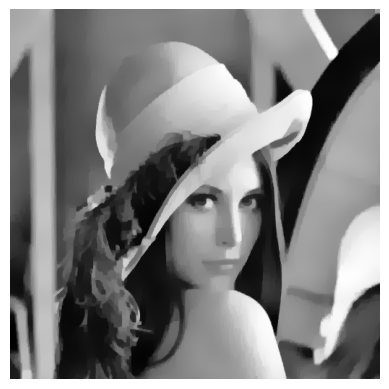

In [ ]:
plt.imshow(denoised_list[0][-1], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

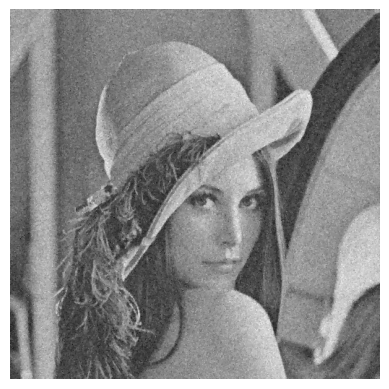

In [ ]:
plt.imshow(denoised_list[1][0], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

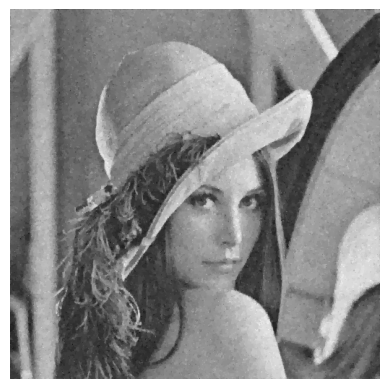

In [ ]:
plt.imshow(denoised_list[1][-2], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

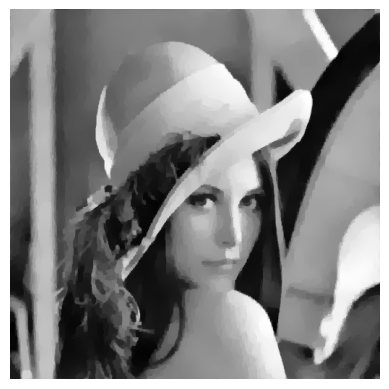

In [ ]:
plt.imshow(denoised_list[1][-1], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

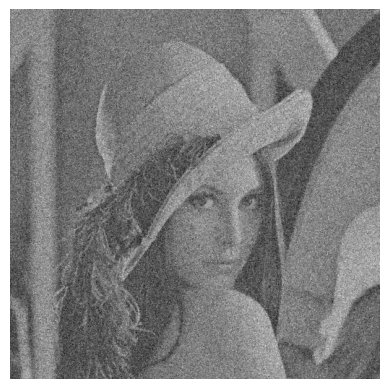

In [ ]:
plt.imshow(denoised_list[2][0], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

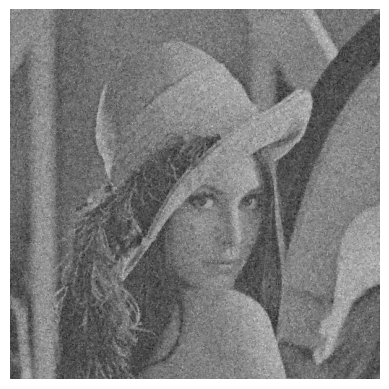

In [ ]:
plt.imshow(denoised_list[2][-2], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

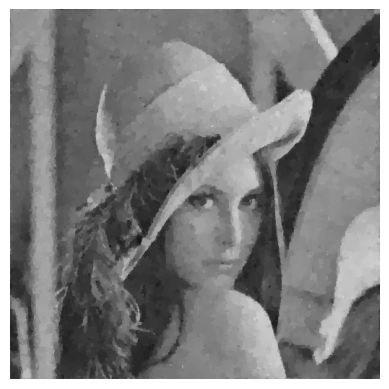

In [ ]:
plt.imshow(denoised_list[2][-1], cmap='gray')
plt.axis('off')

In [ ]:
psnr_list[0][0]

32.08730173952052

In [ ]:
psnr_list[0][-2]

31.23164588213877

In [ ]:
psnr_list[0][-1]

27.750787276651657

In [ ]:
psnr_list[1][0]

24.975824501690163

In [ ]:
psnr_list[1][-2]

28.68321507025321

In [ ]:
psnr_list[1][-1]

27.665038073968713

In [ ]:
psnr_list[2][0]

16.882765874438757

In [ ]:
psnr_list[2][-2]

19.538231130197282

In [ ]:
psnr_list[2][-1]

26.799821918162966